In [ ]:
#Keras model for "Spaceship Titanic" Kaggle Competition

In [23]:
#import necessary packages

import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [24]:
#Read in data, split into train/test/validation data.
train_data = pd.read_csv('../input/spaceship-titanic/train.csv')
test_data = pd.read_csv('../input/spaceship-titanic/test.csv')

target = train_data.Transported

var_list = ['HomePlanet','CryoSleep','Cabin','Destination','Age','VIP','RoomService','FoodCourt','ShoppingMall','Spa', 'VRDeck']

x_train, x_valid, y_train, y_valid = train_test_split(train_data[var_list], target, random_state=1)
x_test = test_data[var_list]

In [43]:
#Impute for missing values and add back in columns. By using most frequent, allows for categorical to also be imputed. 
median_imputer = SimpleImputer(strategy='most_frequent')

imputed_x_train = pd.DataFrame(median_imputer.fit_transform(x_train))
imputed_x_valid = pd.DataFrame(median_imputer.transform(x_valid))
imputed_x_test = pd.DataFrame(median_imputer.transform(x_test))

imputed_x_train.columns=x_train.columns
imputed_x_valid.columns=x_valid.columns
imputed_x_test.columns=x_test.columns

#Now, seperate into categorical, integer, and cabin data. One-hot encode categoricals,
#and process cabin data, then combine all back into a single DataFrame for train, 
#valid, and test.

#Cabin is a bit of a process. It requires a function which iterates
#through passenger cabin data, pulls individual attributes (deck, number, and side),
#and creates one column DataFrames for each. We then can one-hot encode the categoricals
#(deck and side), and then combine, and then combine again!

def cabin_2000(df):
    deck_temp = []
    num_temp = []
    side_temp = []
    for i in df.Cabin:
        #Determine index of second slash, separate into 3 strings and append to list
        index = int(i.rfind('/'))
        deck_temp.append(i[0])
        num_temp.append(i[2:index])
        side_temp.append(i[-1:])
    #Convert lists to dataframes, one-hot encode categoricals
    deck = pd.get_dummies(pd.DataFrame(deck_temp,columns=['cabin_deck']))
    num = pd.DataFrame(num_temp,columns=['cabin_number'])
    side = pd.get_dummies(pd.DataFrame(side_temp,columns=['cabin_side']))
    #Combine into single DataFrame
    cabin = pd.concat([deck,num,side], axis=1)
    return cabin

cat_variables = ['HomePlanet','CryoSleep','Destination','VIP']
int_variables = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']


x_train_cat = pd.get_dummies(imputed_x_train[cat_variables])
x_train_int = imputed_x_train[int_variables]
cabin_train = cabin_2000(imputed_x_train)
cabin_train2 = cabin_train.drop(['cabin_deck_T'], axis=1)
X_train1 = pd.concat([x_train_cat,x_train_int,cabin_train2],axis=1)

x_valid_cat = pd.get_dummies(imputed_x_valid[cat_variables])
x_valid_int = imputed_x_valid[int_variables]
cabin_valid = cabin_2000(imputed_x_valid)
X_valid1 = pd.concat([x_valid_cat,x_valid_int,cabin_valid],axis=1)

x_test_cat = pd.get_dummies(imputed_x_test[cat_variables])
x_test_int = imputed_x_test[int_variables]
cabin_test = cabin_2000(imputed_x_test)
cabin_test2 = cabin_test.drop(['cabin_deck_T'], axis=1)
X_test1 = pd.concat([x_test_cat,x_test_int,cabin_test2],axis=1)

#Convert DataFrames to floats, and restore column names. 

X_train = pd.DataFrame(np.asarray(X_train1).astype(np.float32))
X_valid = pd.DataFrame(np.asarray(X_valid1).astype(np.float32))
X_test = pd.DataFrame(np.asarray(X_test1).astype(np.float32))

X_train.columns = X_train1.columns
X_valid.columns = X_valid1.columns
X_test.columns = X_test1.columns


In [60]:
#Define dense and batch normalization layers
neural_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[26]),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1,activation='sigmoid'),
])

#Compile model
neural_model.compile(
    optimizer='adam',
    loss = 'mae',
)

#Define early stopping callbacks
early_stopping = keras.callbacks.EarlyStopping(
    patience=7,
    min_delta=0.001,
    restore_best_weights=True,
)

#Fit model
history = neural_model.fit(
    X_train, y_train,
    validation_data=(X_valid,y_valid),
    batch_size=50,
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200
131/131 [==============================] - 3s 6ms/step - loss: 0.2562 - val_loss: 0.2386
Epoch 2/200
131/131 [==============================] - 0s 4ms/step - loss: 0.2235 - val_loss: 0.2250
Epoch 3/200
131/131 [==============================] - 0s 4ms/step - loss: 0.2165 - val_loss: 0.2110
Epoch 4/200
131/131 [==============================] - 0s 4ms/step - loss: 0.2158 - val_loss: 0.2331
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.2127 - val_loss: 0.2143
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 0.2111 - val_loss: 0.2001
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.2114 - val_loss: 0.2432
Epoch 8/200
131/131 [==============================] - 0s 4ms/step - loss: 0.2097 - val_loss: 0.2007
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 0.2107 - val_loss: 0.2023
Epoch 10/200
131/131 [==============================] - 0s 3ms/step - loss: 0.2113 - val_lo

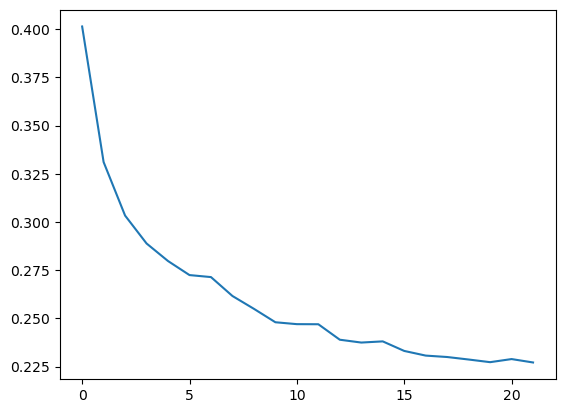

In [80]:
#Epochs vs loss graph
history_df = pd.DataFrame(history.history)
history_df['loss'].plot();

In [79]:
#Predict transportation
preds = neural_model.predict(X_test)

#Convert neural net output (float) into bool
predictions=[]
for i in preds:
    if float(i) > 0.5:
        predictions.append('True')
    else:
        predictions.append('False')
        
#Pull IDs from original test df, and combine with predictions into submission file
ids = test_data.PassengerId
final_preds = pd.DataFrame(predictions,columns=['Transported'])
output = pd.concat([ids,final_preds],axis=1)
output.to_csv('spaceship_titanic_submission_7.csv',index=False)

134/134 [==============================] - 0s 1ms/step
